## Modelling Part 3: Predicting Household Electricity Prices (Low Tension Tariff)
- While the first 2 parts were deemed to be sufficient for a project, I wanted to challenge myself to take this project even further, hence added in this stretch goal of predicting household electricity prices.
- I also felt that this could be useful for all audiences, to understand more about the singapore's consumer electricity market

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import itertools
import warnings

In [20]:
#import price data
tariff = pd.read_csv('./tariff_oilgas_prices.csv')

In [21]:
#import exchange rate data from MAS as the prices are in USD. converting to SGD should improve model performance also
exchange_rate = pd.read_csv('./datasets/Exchange Rates.csv')

In [22]:
#inspect data
exchange_rate.head()

,Date,sgd_per_usd
0,2012-Jan,1.2547
1,2012-Feb,1.2474
2,2012-Mar,1.2572
3,2012-Apr,1.2372
4,2012-May,1.2882


In [23]:
exchange_rate['Date'] = pd.to_datetime(exchange_rate['Date'])

C:\Users\User\AppData\Local\Temp\ipykernel_15404\3793304605.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  exchange_rate['Date'] = pd.to_datetime(exchange_rate['Date'])


In [24]:
exchange_rate

,Date,sgd_per_usd
0,2012-01-01,1.2547
1,2012-02-01,1.2474
2,2012-03-01,1.2572
3,2012-04-01,1.2372
4,2012-05-01,1.2882
...,...,...
157,2025-02-01,1.3490
158,2025-03-01,1.3410
159,2025-04-01,1.3077
160,2025-05-01,1.2885


In [25]:
#i am resampling the data to quarters as low tension tariff is fixed on a quarterly basis by EMA
exchange_rate.set_index('Date', inplace=True)
#.mean() so as to take the average rate of each 3 months
exchange_rate_quarter = exchange_rate.resample('QS').mean()

In [26]:
exchange_rate_quarter.head()

,sgd_per_usd
Date,
2012-01-01,1.253100
2012-04-01,1.266367
2012-07-01,1.241033
2012-10-01,1.221167
2013-01-01,1.239600


In [27]:
tariff['Date'] = pd.to_datetime(tariff['Date'])

In [28]:
tariff.dtypes

Date                    datetime64[ns]
low_tension_domestic           float64
oil_price_usd_barrel           float64
lng_price_usd_MMBtu            float64
dtype: object

In [29]:
tariff = pd.merge(left = tariff, right = exchange_rate, how ='left', on='Date')

In [30]:
tariff.head()

,Date,low_tension_domestic,oil_price_usd_barrel,lng_price_usd_MMBtu,sgd_per_usd
0,2025-06-01,28.12,68.169000,12.963,1.2758
1,2025-05-01,28.12,62.167619,11.678,1.2885
2,2025-04-01,28.12,63.536667,11.569,1.3077
3,2025-03-01,28.12,68.239048,13.118,1.3410
4,2025-02-01,28.12,71.533158,14.721,1.3490


In [31]:
#now resampling the tariff data as well
tariff.set_index('Date', inplace=True)

tariff = tariff.resample('QS').mean()


In [32]:
tariff=tariff.sort_index(ascending=True)

In [33]:
tariff.head()

,low_tension_domestic,oil_price_usd_barrel,lng_price_usd_MMBtu,sgd_per_usd
Date,,,,
2012-01-01,27.59,102.878409,17.530000,1.253100
2012-04-01,28.78,93.426293,19.093333,1.266367
2012-07-01,28.08,92.180076,18.750000,1.241033
2012-10-01,27.27,87.960744,17.206667,1.221167
2013-01-01,26.28,94.334705,17.940000,1.239600


In [34]:
tariff['oil_price_sgd_barrel'] = tariff['oil_price_usd_barrel'] * tariff['sgd_per_usd']

In [35]:
tariff['lng_price_sgd_MMBtu'] = tariff['lng_price_usd_MMBtu'] * tariff['sgd_per_usd']

<Axes: xlabel='Date'>

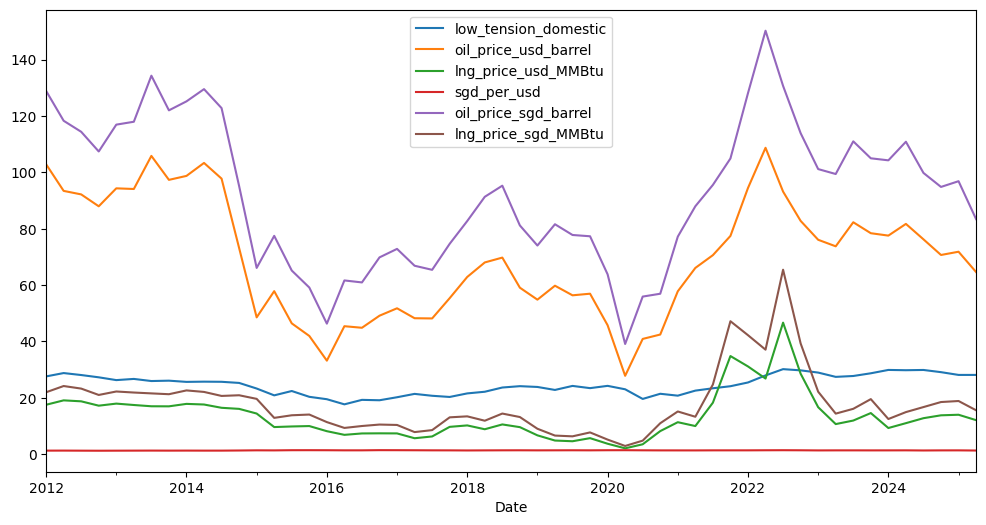

In [36]:
tariff.plot(figsize=(12,6))

# As we had initially suspected, there seems to be a trend between oil prices, LNG prices, and low tension tariff

## So to account for oil prices and LNG prices in the modelling, SARIMAX is used
### To first prepare the train & test data. Will use the last 4 quarters as testing data

In [37]:
train = tariff.iloc[:-4]
test = tariff.iloc[-4:]

y_train = train["low_tension_domestic"]
y_test = test["low_tension_domestic"]
exog_train = train[["oil_price_sgd_barrel", "lng_price_sgd_MMBtu"]]
exog_test = test[["oil_price_sgd_barrel", "lng_price_sgd_MMBtu"]]

In [38]:
test

,low_tension_domestic,oil_price_usd_barrel,lng_price_usd_MMBtu,sgd_per_usd,oil_price_sgd_barrel,lng_price_sgd_MMBtu
Date,,,,,,
2024-07-01,29.88,76.239879,12.766000,1.309067,99.803084,16.711545
2024-10-01,29.10,70.684365,13.787667,1.341633,94.832500,18.497993
2025-01-01,28.12,71.838235,13.988333,1.348400,96.866676,18.861869
2025-04-01,28.12,64.624429,12.070000,1.290667,83.408596,15.578347


In [ ]:
warnings.filterwarnings("ignore")

#tests the hyperparameters non-seasonal p d q between 0-2 and seasonal P D Q and gives the set with best AIC
p = d = q = range(0, 3)      
P = D = Q = range(0, 2)       
s = 4 #s = 4 as it is quarterly frequency

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q))

best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_model = None

print("Running grid search...")

for order in pdq:
    for seasonal_order in seasonal_pdq:
        seasonal_order_full = (seasonal_order[0], seasonal_order[1], seasonal_order[2], s)
        try:
            model = SARIMAX(y_train,
                            exog=exog_train,
                            order=order,
                            seasonal_order=seasonal_order_full,
                            enforce_stationarity=False,
                            enforce_invertibility=False)

            results = model.fit(disp=False)
            current_aic = results.aic

            if current_aic < best_aic:
                best_aic = current_aic
                best_order = order
                best_seasonal_order = seasonal_order_full
                best_model = results

            print(f"Tested SARIMAX{order}x{seasonal_order_full} - AIC: {current_aic:.2f}")

        except Exception as e:
           
            continue

print("\n✅ Best Model:")
print(f"Order: {best_order}")
print(f"Seasonal Order: {best_seasonal_order}")
print(f"AIC: {best_aic:.2f}")

Running grid search...
Tested SARIMAX(0, 0, 0)x(0, 0, 0, 4) - AIC: 291.70
Tested SARIMAX(0, 0, 0)x(0, 0, 1, 4) - AIC: 267.79
Tested SARIMAX(0, 0, 0)x(0, 1, 0, 4) - AIC: 209.22
Tested SARIMAX(0, 0, 0)x(0, 1, 1, 4) - AIC: 192.87
Tested SARIMAX(0, 0, 0)x(1, 0, 0, 4) - AIC: 276.14
Tested SARIMAX(0, 0, 0)x(1, 0, 1, 4) - AIC: 267.75
Tested SARIMAX(0, 0, 0)x(1, 1, 0, 4) - AIC: 197.26
Tested SARIMAX(0, 0, 0)x(1, 1, 1, 4) - AIC: 193.33
Tested SARIMAX(0, 0, 1)x(0, 0, 0, 4) - AIC: 269.53
Tested SARIMAX(0, 0, 1)x(0, 0, 1, 4) - AIC: 246.13
Tested SARIMAX(0, 0, 1)x(0, 1, 0, 4) - AIC: 189.59
Tested SARIMAX(0, 0, 1)x(0, 1, 1, 4) - AIC: 177.02
Tested SARIMAX(0, 0, 1)x(1, 0, 0, 4) - AIC: 199.04
Tested SARIMAX(0, 0, 1)x(1, 0, 1, 4) - AIC: 247.95
Tested SARIMAX(0, 0, 1)x(1, 1, 0, 4) - AIC: 184.50
Tested SARIMAX(0, 0, 1)x(1, 1, 1, 4) - AIC: 176.64
Tested SARIMAX(0, 0, 2)x(0, 0, 0, 4) - AIC: 252.56
Tested SARIMAX(0, 0, 2)x(0, 0, 1, 4) - AIC: 235.43
Tested SARIMAX(0, 0, 2)x(0, 1, 0, 4) - AIC: 177.78
Tested S

In [ ]:
#same thing, but tests the hyperparameters non-seasonal p d q between 0-2 and seasonal P D Q and gives the set with best RMSE

p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 4

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q))

best_rmse = float("inf")
best_order = None
best_seasonal_order = None
best_model = None

print("Running grid search for best RMSE...")

for order in pdq:
    for seasonal in seasonal_pdq:
        seasonal_order = (seasonal[0], seasonal[1], seasonal[2], s)
        try:
            model = SARIMAX(y_train,
                            exog=exog_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)

            # Predict on test set
            y_pred = results.predict(start=y_test.index[0],
                                     end=y_test.index[-1],
                                     exog=exog_test)

            # Compute RMSE
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = results

            print(f"Tested SARIMAX{order}x{seasonal_order} - RMSE: {rmse:.2f}")

        except Exception as e:
            continue

print("\n✅ Best Model Based on RMSE:")
print(f"Order: {best_order}")
print(f"Seasonal Order: {best_seasonal_order}")
print(f"RMSE: {best_rmse:.2f}")

Running grid search for best RMSE...
Tested SARIMAX(0, 0, 0)x(0, 0, 0, 4) - RMSE: 5.22
Tested SARIMAX(0, 0, 0)x(0, 0, 1, 4) - RMSE: 6.43
Tested SARIMAX(0, 0, 0)x(0, 1, 0, 4) - RMSE: 1.59
Tested SARIMAX(0, 0, 0)x(0, 1, 1, 4) - RMSE: 2.02
Tested SARIMAX(0, 0, 0)x(1, 0, 0, 4) - RMSE: 1.58
Tested SARIMAX(0, 0, 0)x(1, 0, 1, 4) - RMSE: 7.16
Tested SARIMAX(0, 0, 0)x(1, 1, 0, 4) - RMSE: 1.53
Tested SARIMAX(0, 0, 0)x(1, 1, 1, 4) - RMSE: 1.93
Tested SARIMAX(0, 0, 1)x(0, 0, 0, 4) - RMSE: 5.59
Tested SARIMAX(0, 0, 1)x(0, 0, 1, 4) - RMSE: 6.28
Tested SARIMAX(0, 0, 1)x(0, 1, 0, 4) - RMSE: 1.48
Tested SARIMAX(0, 0, 1)x(0, 1, 1, 4) - RMSE: 1.94
Tested SARIMAX(0, 0, 1)x(1, 0, 0, 4) - RMSE: 1.47
Tested SARIMAX(0, 0, 1)x(1, 0, 1, 4) - RMSE: 1.73
Tested SARIMAX(0, 0, 1)x(1, 1, 0, 4) - RMSE: 1.37
Tested SARIMAX(0, 0, 1)x(1, 1, 1, 4) - RMSE: 1.63
Tested SARIMAX(0, 0, 2)x(0, 0, 0, 4) - RMSE: 6.06
Tested SARIMAX(0, 0, 2)x(0, 0, 1, 4) - RMSE: 6.05
Tested SARIMAX(0, 0, 2)x(0, 1, 0, 4) - RMSE: 1.21
Tested SARIMA

In [ ]:
#to test the one with best AIC
model = SARIMAX(y_train,
                exog=exog_train,
                order=(0,2,2),
                seasonal_order=(0,1,1,4), 
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                low_tension_domestic   No. Observations:                   50
Model:             SARIMAX(0, 2, 2)x(0, 1, [1], 4)   Log Likelihood                 -67.672
Date:                             Thu, 24 Jul 2025   AIC                            147.345
Time:                                     15:29:26   BIC                            157.010
Sample:                                 01-01-2012   HQIC                           150.752
                                      - 04-01-2024                                         
Covariance Type:                               opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
oil_price_usd_barrel    -0.0074      0.027     -0.274      0.784      -0.060       0.0

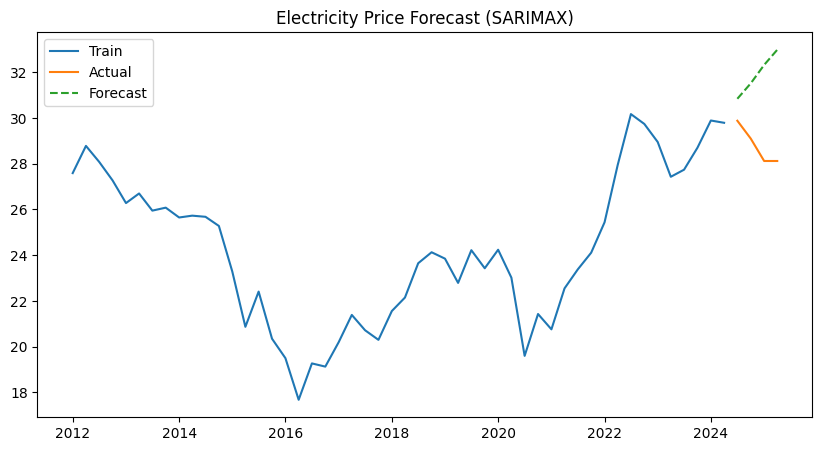

In [ ]:
forecast = results.predict(start=test.index[0],
                           end=test.index[-1],
                           exog=exog_test)

# Plot
plt.figure(figsize=(10,5))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(forecast.index, forecast, label="Forecast", linestyle="--")
plt.legend()
plt.title("Electricity Price Forecast (SARIMAX)")
plt.show()

In [ ]:
mae = mean_absolute_error(y_test, forecast)
rmse = np.sqrt(mean_squared_error(y_test, forecast))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 0.25, RMSE: 0.32


In [ ]:
#and now to test the one with best RMSE
model = SARIMAX(y_train,
                exog=exog_train,
                order=(1,1,2),
                seasonal_order=(1,0,1,4),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                low_tension_domestic   No. Observations:                   50
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 4)   Log Likelihood                 -68.698
Date:                             Thu, 24 Jul 2025   AIC                            153.397
Time:                                     15:30:16   BIC                            167.298
Sample:                                 01-01-2012   HQIC                           158.492
                                      - 04-01-2024                                         
Covariance Type:                               opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
oil_price_usd_barrel    -0.0088      0.020     -0.451      0.652      -0.047       0.0

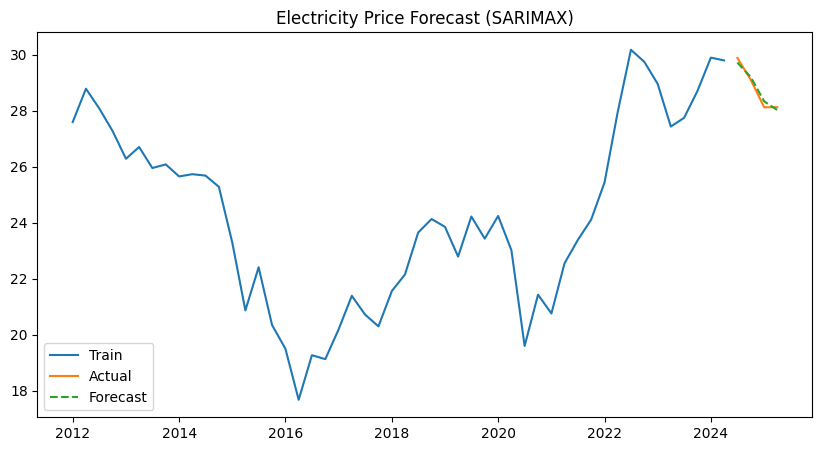

In [ ]:
forecast = results.predict(start=test.index[0],
                           end=test.index[-1],
                           exog=exog_test)

# Plot
plt.figure(figsize=(10,5))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(forecast.index, forecast, label="Forecast", linestyle="--")
plt.legend()
plt.title("Electricity Price Forecast (SARIMAX)")
plt.show()

## It seems like the 2nd model performed the best

## To make prediction for the SARIMAX model, we will need to first predict the values for the exogenous variables

#### Firstly, for oil_price_sgd_barrel

In [40]:
tariff.head()

,low_tension_domestic,oil_price_usd_barrel,lng_price_usd_MMBtu,sgd_per_usd,oil_price_sgd_barrel,lng_price_sgd_MMBtu
Date,,,,,,
2012-01-01,27.59,102.878409,17.530000,1.253100,128.916934,21.966843
2012-04-01,28.78,93.426293,19.093333,1.266367,118.311943,24.179161
2012-07-01,28.08,92.180076,18.750000,1.241033,114.398546,23.269375
2012-10-01,27.27,87.960744,17.206667,1.221167,107.414729,21.012208
2013-01-01,26.28,94.334705,17.940000,1.239600,116.937300,22.238424


## To likewise set the train and test data to be same period as what we did for tariff prediction.
## However, SARIMAX is not used, as the assumption is that it does not have exogenous variables.
## We first test ARIMA

In [41]:
oil_train = tariff['oil_price_sgd_barrel'].iloc[:-4]
oil_test = tariff['oil_price_sgd_barrel'].iloc[-4:]

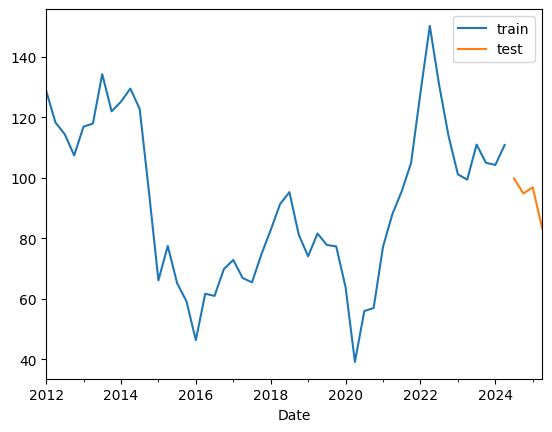

In [42]:
oil_train.plot(label="train")
oil_test.plot(label="test")
plt.legend()

plt.show()

In [ ]:
#hyperparameter turing for best RMSE

p = range(0, 4)
d = range(0, 4)
q = range(0, 4)
pdq = list(itertools.product(p, d, q))

best_rmse = float('inf')
best_order = None

for order in pdq:
    try:
        model = ARIMA(oil_train, order=order)
        model_fit = model.fit()

        # Forecast for length of test set
        forecast = model_fit.forecast(steps=len(oil_test))

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(oil_test, forecast))

        print(f"Tested ARIMA{order} - RMSE: {rmse:.3f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_order = order
    except Exception as e:
        print(f"ARIMA{order} failed: {e}")
        continue

print(f"\nBest order by RMSE: {best_order} with RMSE: {best_rmse:.3f}")

Tested ARIMA(0, 0, 0) - RMSE: 4.346
Tested ARIMA(0, 0, 1) - RMSE: 2.962
Tested ARIMA(0, 0, 2) - RMSE: 6.176
Tested ARIMA(0, 0, 3) - RMSE: 5.254
Tested ARIMA(0, 1, 0) - RMSE: 11.631
Tested ARIMA(0, 1, 1) - RMSE: 12.331
Tested ARIMA(0, 1, 2) - RMSE: 12.769
Tested ARIMA(0, 1, 3) - RMSE: 13.305
Tested ARIMA(0, 2, 0) - RMSE: 22.919
Tested ARIMA(0, 2, 1) - RMSE: 12.195
Tested ARIMA(0, 2, 2) - RMSE: 11.431
Tested ARIMA(0, 2, 3) - RMSE: 11.888
Tested ARIMA(0, 3, 0) - RMSE: 52.778
Tested ARIMA(0, 3, 1) - RMSE: 24.585
Tested ARIMA(0, 3, 2) - RMSE: 20.064
Tested ARIMA(0, 3, 3) - RMSE: 21.215
Tested ARIMA(1, 0, 0) - RMSE: 10.330
Tested ARIMA(1, 0, 1) - RMSE: 10.299
Tested ARIMA(1, 0, 2) - RMSE: 10.419
Tested ARIMA(1, 0, 3) - RMSE: 10.850
Tested ARIMA(1, 1, 0) - RMSE: 12.537
Tested ARIMA(1, 1, 1) - RMSE: 12.528
Tested ARIMA(1, 1, 2) - RMSE: 13.364
Tested ARIMA(1, 1, 3) - RMSE: 11.388
Tested ARIMA(1, 2, 0) - RMSE: 18.737
Tested ARIMA(1, 2, 1) - RMSE: 11.556
Tested ARIMA(1, 2, 2) - RMSE: 11.580
Teste

In [ ]:
#and now for bets AIC
p = range(0, 4)
d = range(0, 4)
q = range(0, 4)
pdq = list(itertools.product(p, d, q))

best_aic = float('inf')
best_order = None

for order in pdq:
    try:
        model = ARIMA(oil_train, order=order)
        model_fit = model.fit()

        aic = model_fit.aic
        print(f"Tested ARIMA{order} - AIC: {aic:.2f}")

        if aic < best_aic:
            best_aic = aic
            best_order = order
    except Exception as e:
        print(f"ARIMA{order} failed: {e}")
        continue

print(f"\nBest order by AIC: {best_order} with AIC: {best_aic:.2f}")

Tested ARIMA(0, 0, 0) - AIC: 452.80
Tested ARIMA(0, 0, 1) - AIC: 411.38
Tested ARIMA(0, 0, 2) - AIC: 388.76
Tested ARIMA(0, 0, 3) - AIC: 383.83
Tested ARIMA(0, 1, 0) - AIC: 361.71
Tested ARIMA(0, 1, 1) - AIC: 361.94
Tested ARIMA(0, 1, 2) - AIC: 363.71
Tested ARIMA(0, 1, 3) - AIC: 365.04
Tested ARIMA(0, 2, 0) - AIC: 377.57
Tested ARIMA(0, 2, 1) - AIC: 361.06
Tested ARIMA(0, 2, 2) - AIC: 361.10
Tested ARIMA(0, 2, 3) - AIC: 362.71
Tested ARIMA(0, 3, 0) - AIC: 418.61
Tested ARIMA(0, 3, 1) - AIC: 376.58
Tested ARIMA(0, 3, 2) - AIC: 364.46
Tested ARIMA(0, 3, 3) - AIC: 364.12
Tested ARIMA(1, 0, 0) - AIC: 372.29
Tested ARIMA(1, 0, 1) - AIC: 371.81
Tested ARIMA(1, 0, 2) - AIC: 372.93
Tested ARIMA(1, 0, 3) - AIC: 374.76
Tested ARIMA(1, 1, 0) - AIC: 361.83
Tested ARIMA(1, 1, 1) - AIC: 363.83
Tested ARIMA(1, 1, 2) - AIC: 365.33
Tested ARIMA(1, 1, 3) - AIC: 366.28
Tested ARIMA(1, 2, 0) - AIC: 371.65
Tested ARIMA(1, 2, 1) - AIC: 360.88
Tested ARIMA(1, 2, 2) - AIC: 362.88
Tested ARIMA(1, 2, 3) - AIC:

### Testing with the model using hyperparameters with lowest RMSE

In [43]:
#lowest rmse
model = ARIMA(oil_train, order=(0, 0, 1)).fit()

y_pred = model.predict(start="2024-07-01", end="2025-04-01")

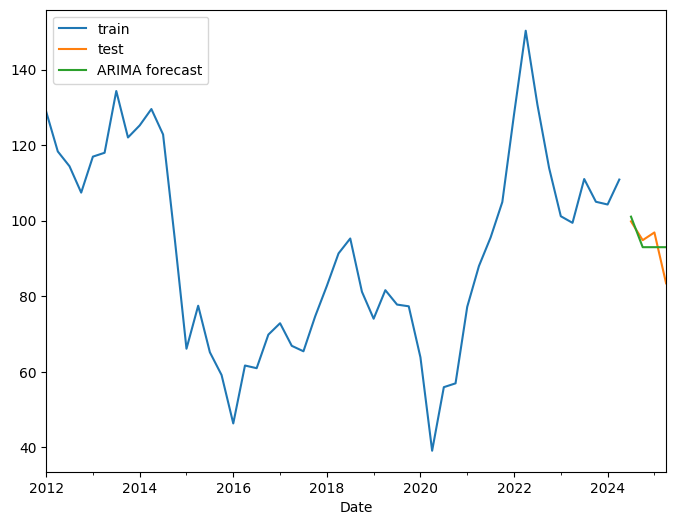

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))

oil_train.plot(label="train")
oil_test.plot(label="test")
y_pred.plot( label="ARIMA forecast")
plt.legend()

plt.show()

### Lowest AIC

In [45]:
model = ARIMA(oil_train, order=(1, 2, 1)).fit()

y_pred = model.predict(start="2024-07-01", end="2025-04-01")

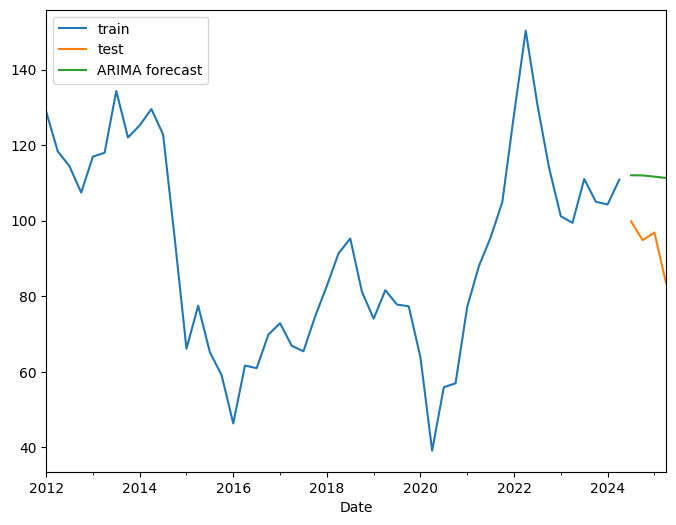

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))

oil_train.plot(label="train")
oil_test.plot(label="test")
y_pred.plot( label="ARIMA forecast")
plt.legend()

plt.show()

#### Didn't seem to work well

## So let's try SARIMA instead, which I think will work well, since there seems to be seasonality in the prices

In [48]:
#test for best p d q & P D Q value for best RMSE
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 4

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q))

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

for order in pdq:
    for seasonal in seasonal_pdq:
        try:
            seasonal_order = seasonal + (s,)
            model = SARIMAX(oil_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=False)

            forecast = model_fit.forecast(steps=len(oil_test))
            rmse = np.sqrt(mean_squared_error(oil_test, forecast))

            print(f"SARIMA{order}x{seasonal_order} - RMSE: {rmse:.3f}")

            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal_order
        except Exception as e:
            print(f"SARIMA{order}x{seasonal + (s,)} failed: {e}")
            continue

print(f"\nBest SARIMA order: {best_order} x {best_seasonal_order} with RMSE: {best_rmse:.3f}")

SARIMA(0, 0, 0)x(0, 0, 0, 4) - RMSE: 93.933
SARIMA(0, 0, 0)x(0, 0, 1, 4) - RMSE: 35.628
SARIMA(0, 0, 0)x(0, 1, 0, 4) - RMSE: 16.106
SARIMA(0, 0, 0)x(0, 1, 1, 4) - RMSE: 16.143
SARIMA(0, 0, 0)x(1, 0, 0, 4) - RMSE: 11.193
SARIMA(0, 0, 0)x(1, 0, 1, 4) - RMSE: 11.753
SARIMA(0, 0, 0)x(1, 1, 0, 4) - RMSE: 16.102
SARIMA(0, 0, 0)x(1, 1, 1, 4) - RMSE: 8.496
SARIMA(0, 0, 1)x(0, 0, 0, 4) - RMSE: 83.018
SARIMA(0, 0, 1)x(0, 0, 1, 4) - RMSE: 20.509
SARIMA(0, 0, 1)x(0, 1, 0, 4) - RMSE: 16.340
SARIMA(0, 0, 1)x(0, 1, 1, 4) - RMSE: 16.025
SARIMA(0, 0, 1)x(1, 0, 0, 4) - RMSE: 9.973
SARIMA(0, 0, 1)x(1, 0, 1, 4) - RMSE: 9.948
SARIMA(0, 0, 1)x(1, 1, 0, 4) - RMSE: 15.963
SARIMA(0, 0, 1)x(1, 1, 1, 4) - RMSE: 26.245
SARIMA(0, 0, 2)x(0, 0, 0, 4) - RMSE: 75.929
SARIMA(0, 0, 2)x(0, 0, 1, 4) - RMSE: 21.312
SARIMA(0, 0, 2)x(0, 1, 0, 4) - RMSE: 20.382
SARIMA(0, 0, 2)x(0, 1, 1, 4) - RMSE: 9.342
SARIMA(0, 0, 2)x(1, 0, 0, 4) - RMSE: 13.684
SARIMA(0, 0, 2)x(1, 0, 1, 4) - RMSE: 8.991
SARIMA(0, 0, 2)x(1, 1, 0, 4) - RMSE: 

In [ ]:
#now for best aic
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 4 

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q))

best_aic = float('inf')
best_order = None
best_seasonal_order = None

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(oil_train,
                            order=order,
                            seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=False)

            aic = model_fit.aic
            print(f"Tested SARIMA{order}x{seasonal_order + (s,)} - AIC: {aic:.2f}")

            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_seasonal_order = seasonal_order + (s,)
        except Exception as e:
            print(f"SARIMA{order}x{seasonal_order + (s,)} failed: {e}")
            continue

print(f"\nBest SARIMA order: {best_order} x {best_seasonal_order} with AIC: {best_aic:.2f}")

Tested SARIMA(0, 0, 0)x(0, 0, 0, 4) - AIC: 560.25
Tested SARIMA(0, 0, 0)x(0, 0, 1, 4) - AIC: 472.82
Tested SARIMA(0, 0, 0)x(0, 1, 0, 4) - AIC: 408.61
Tested SARIMA(0, 0, 0)x(0, 1, 1, 4) - AIC: 377.55
Tested SARIMA(0, 0, 0)x(1, 0, 0, 4) - AIC: 416.50
Tested SARIMA(0, 0, 0)x(1, 0, 1, 4) - AIC: 410.43
Tested SARIMA(0, 0, 0)x(1, 1, 0, 4) - AIC: 385.84
Tested SARIMA(0, 0, 0)x(1, 1, 1, 4) - AIC: 377.80
Tested SARIMA(0, 0, 1)x(0, 0, 0, 4) - AIC: 491.32
Tested SARIMA(0, 0, 1)x(0, 0, 1, 4) - AIC: 412.41
Tested SARIMA(0, 0, 1)x(0, 1, 0, 4) - AIC: 365.51
Tested SARIMA(0, 0, 1)x(0, 1, 1, 4) - AIC: 336.79
Tested SARIMA(0, 0, 1)x(1, 0, 0, 4) - AIC: 380.19
Tested SARIMA(0, 0, 1)x(1, 0, 1, 4) - AIC: 367.17
Tested SARIMA(0, 0, 1)x(1, 1, 0, 4) - AIC: 351.86
Tested SARIMA(0, 0, 1)x(1, 1, 1, 4) - AIC: 336.78
Tested SARIMA(0, 0, 2)x(0, 0, 0, 4) - AIC: 443.79
Tested SARIMA(0, 0, 2)x(0, 0, 1, 4) - AIC: 387.53
Tested SARIMA(0, 0, 2)x(0, 1, 0, 4) - AIC: 351.61
Tested SARIMA(0, 0, 2)x(0, 1, 1, 4) - AIC: 314.18


In [ ]:
#testing the hyperparameters with lowest RMSE
seasonal_model = SARIMAX(oil_train,
                         order=(2, 0, 1),
                         seasonal_order=(1, 1, 1, 4),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

y_pred_seasonal = seasonal_model.predict(start="2024-07-01", end="2025-04-01")

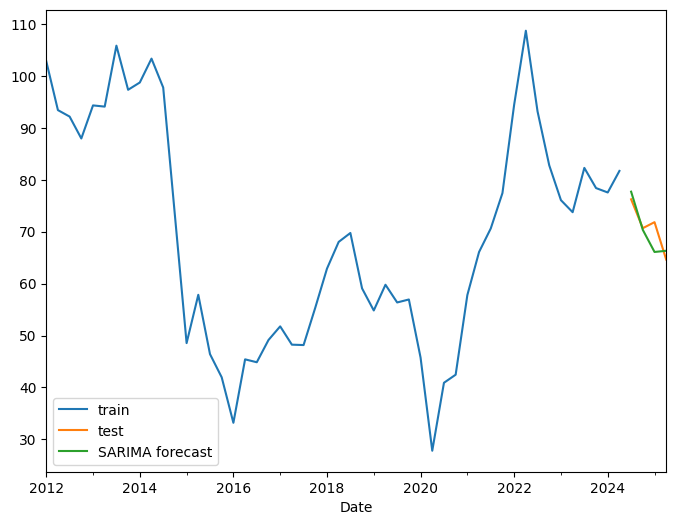

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

oil_train.plot(label="train")
oil_test.plot(label="test")
y_pred_seasonal.plot( label="SARIMA forecast")
plt.legend()

plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(oil_test, y_pred_seasonal))
print(f'RMSE: {rmse}')
print(f'AIC: {seasonal_model.aic}')

RMSE: 3.0878487837043385
AIC: 311.6608392640999


In [ ]:
#now the one with lowest AIC
seasonal_model = SARIMAX(oil_train,
                         order=(0, 2, 2),
                         seasonal_order=(0, 1, 1, 4),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

y_pred_seasonal = seasonal_model.predict(start="2024-07-01", end="2025-04-01")

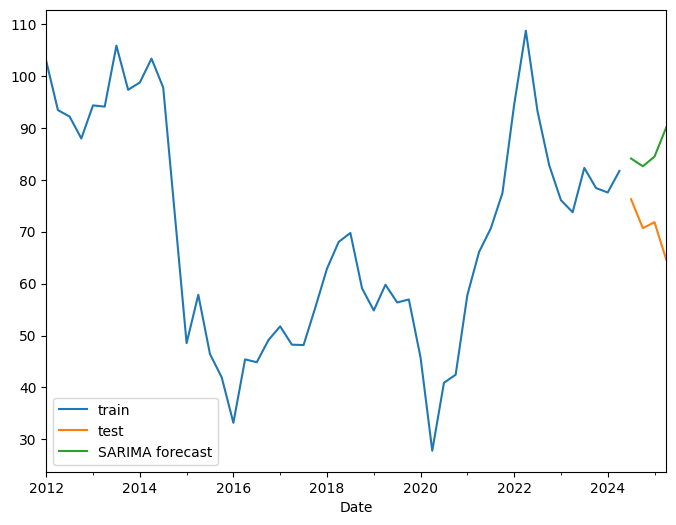

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

oil_train.plot(label="train")
oil_test.plot(label="test")
y_pred_seasonal.plot( label="SARIMA forecast")
plt.legend()

plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(oil_test, y_pred_seasonal))
print(f'RMSE: {rmse}')
print(f'AIC: {seasonal_model.aic}')

RMSE: 15.906078288797099
AIC: 289.7502478095057


## Testing around more to see if other higher values can fit better

In [ ]:
#testing more
seasonal_model = SARIMAX(oil_train,
                         order=(0, 2, 2),
                         seasonal_order=(0, 2, 2, 4),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

y_pred_seasonal = seasonal_model.predict(start="2024-07-01", end="2025-04-01")

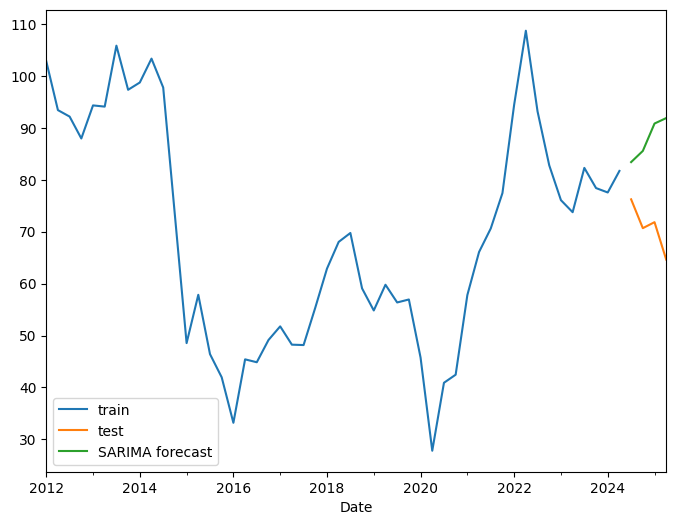

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

oil_train.plot(label="train")
oil_test.plot(label="test")
y_pred_seasonal.plot( label="SARIMA forecast")
plt.legend()

plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(oil_test, y_pred_seasonal))
print(f'RMSE: {rmse}')
print(f'AIC: {seasonal_model.aic}')

RMSE: 18.557566967981725
AIC: 245.90127979628744


In [ ]:
#testing more
seasonal_model = SARIMAX(oil_train,
                         order=(2, 0, 3),
                         seasonal_order=(1, 1, 1, 4),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

y_pred_seasonal = seasonal_model.predict(start="2024-07-01", end="2025-04-01")

In [ ]:
rmse = np.sqrt(mean_squared_error(oil_test, y_pred_seasonal))
print(f'RMSE: {rmse}')
print(f'AIC: {seasonal_model.aic}')

RMSE: 3.182277804079323
AIC: 297.8126898756519


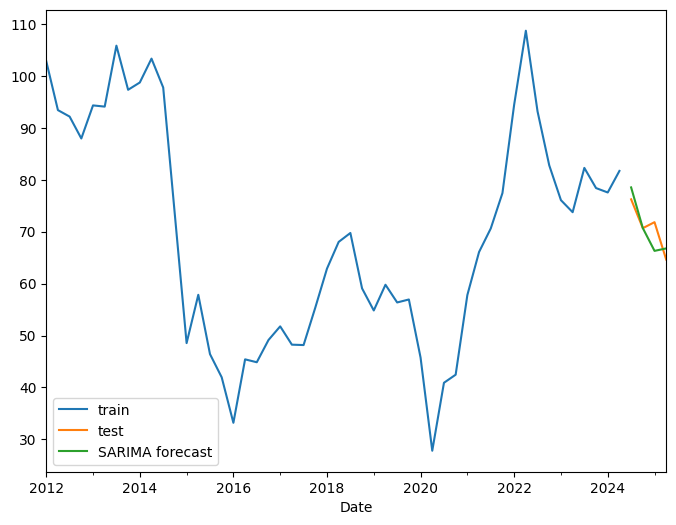

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

oil_train.plot(label="train")
oil_test.plot(label="test")
y_pred_seasonal.plot( label="SARIMA forecast")
plt.legend()

plt.show()

#### 1st and last model seems to work best. to compare against full data and pick the hyperparameters resulting in lowest AIC

In [49]:
oil_train = tariff['oil_price_sgd_barrel']

In [50]:
seasonal_model = SARIMAX(oil_train,
                         order=(2, 0, 3),
                         seasonal_order=(1, 1, 1, 4),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

y_pred_seasonal = seasonal_model.predict(start="2025-07-01", end="2026-10-01")

In [51]:
print(f'AIC: {seasonal_model.aic}')

AIC: 349.14192840920373


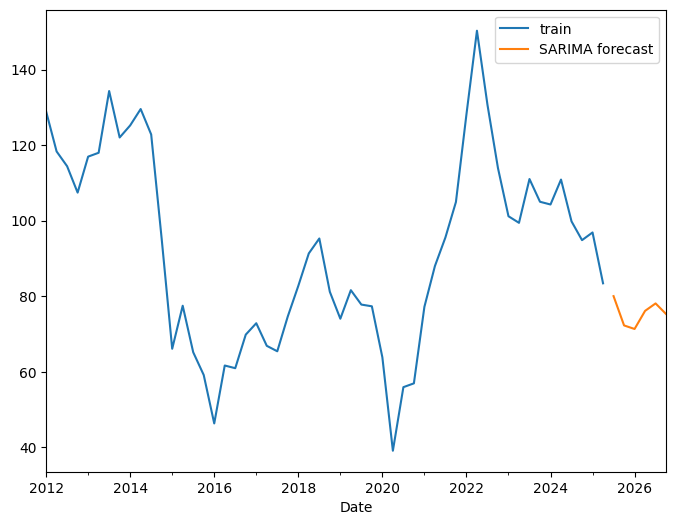

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))

oil_train.plot(label="train")
y_pred_seasonal.plot( label="SARIMA forecast")
plt.legend()

plt.show()

In [53]:
seasonal_model = SARIMAX(oil_train,
                         order=(2, 0, 1),
                         seasonal_order=(1, 1, 1, 4),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

y_pred_seasonal = seasonal_model.predict(start="2025-07-01", end="2026-10-01")

In [54]:
print(f'AIC: {seasonal_model.aic}')

AIC: 362.12861830505136


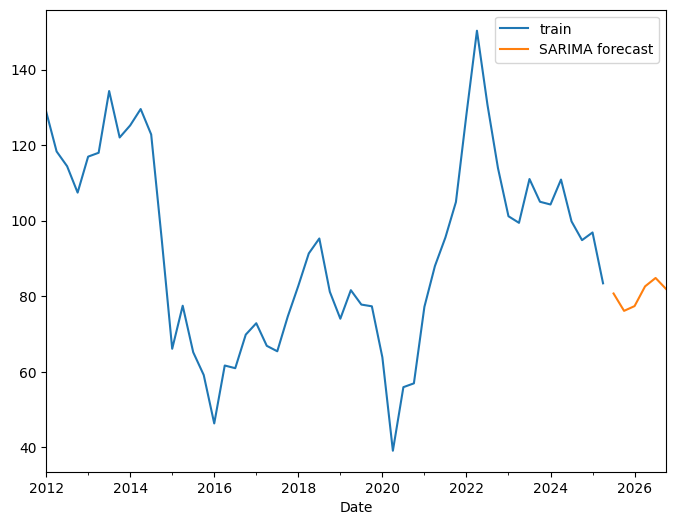

In [55]:
fig, ax = plt.subplots(figsize=(8, 6))

oil_train.plot(label="train")
y_pred_seasonal.plot( label="SARIMA forecast")
plt.legend()

plt.show()

### q = 3 narrowly edges out

#### Now to predict the values for until end of 2026

In [56]:
seasonal_model = SARIMAX(oil_train,
                         order=(2, 0, 3),
                         seasonal_order=(1, 1, 1, 4),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

y_pred_seasonal = seasonal_model.predict(start="2025-07-01", end="2026-10-01")

In [57]:
oil_pred = y_pred_seasonal

In [58]:
#now for lng prices

lng_train = tariff['lng_price_sgd_MMBtu'].iloc[:-4]
lng_test = tariff['lng_price_sgd_MMBtu'].iloc[-4:]

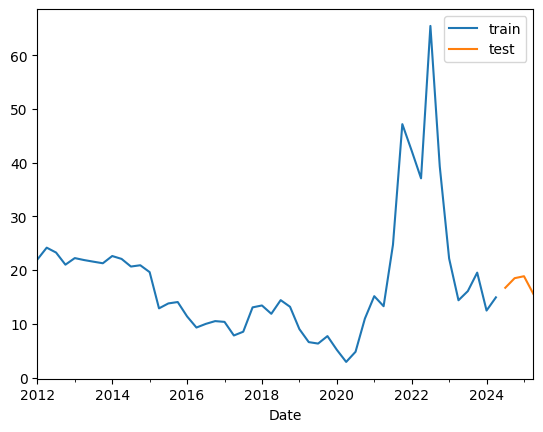

In [59]:
lng_train.plot(label="train")
lng_test.plot(label="test")
plt.legend()

plt.show()

## Now for LNG

In [ ]:
#test for best p d q and P D Q value for best RMSE
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 4

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q))

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

for order in pdq:
    for seasonal in seasonal_pdq:
        try:
            seasonal_order = seasonal + (s,)
            model = SARIMAX(lng_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=False)

            forecast = model_fit.forecast(steps=len(lng_test))
            rmse = np.sqrt(mean_squared_error(lng_test, forecast))

            print(f"SARIMA{order}x{seasonal_order} - RMSE: {rmse:.3f}")

            if rmse < best_rmse:
                best_rmse = rmse
                best_order = order
                best_seasonal_order = seasonal_order
        except Exception as e:
            print(f"SARIMA{order}x{seasonal + (s,)} failed: {e}")
            continue

print(f"\nBest SARIMA order: {best_order} x {best_seasonal_order} with RMSE: {best_rmse:.3f}")

SARIMA(0, 0, 0)x(0, 0, 0, 4) - RMSE: 13.176
SARIMA(0, 0, 0)x(0, 0, 1, 4) - RMSE: 12.503
SARIMA(0, 0, 0)x(0, 1, 0, 4) - RMSE: 2.483
SARIMA(0, 0, 0)x(0, 1, 1, 4) - RMSE: 1.108
SARIMA(0, 0, 0)x(1, 0, 0, 4) - RMSE: 4.479
SARIMA(0, 0, 0)x(1, 0, 1, 4) - RMSE: 2.908
SARIMA(0, 0, 0)x(1, 1, 0, 4) - RMSE: 4.310
SARIMA(0, 0, 0)x(1, 1, 1, 4) - RMSE: 1.410
SARIMA(0, 0, 1)x(0, 0, 0, 4) - RMSE: 12.542
SARIMA(0, 0, 1)x(0, 0, 1, 4) - RMSE: 8.532
SARIMA(0, 0, 1)x(0, 1, 0, 4) - RMSE: 3.381
SARIMA(0, 0, 1)x(0, 1, 1, 4) - RMSE: 2.858
SARIMA(0, 0, 1)x(1, 0, 0, 4) - RMSE: 4.642
SARIMA(0, 0, 1)x(1, 0, 1, 4) - RMSE: 3.573
SARIMA(0, 0, 1)x(1, 1, 0, 4) - RMSE: 6.647
SARIMA(0, 0, 1)x(1, 1, 1, 4) - RMSE: 1.782
SARIMA(0, 0, 2)x(0, 0, 0, 4) - RMSE: 10.231
SARIMA(0, 0, 2)x(0, 0, 1, 4) - RMSE: 8.180
SARIMA(0, 0, 2)x(0, 1, 0, 4) - RMSE: 3.540
SARIMA(0, 0, 2)x(0, 1, 1, 4) - RMSE: 2.426
SARIMA(0, 0, 2)x(1, 0, 0, 4) - RMSE: 4.911
SARIMA(0, 0, 2)x(1, 0, 1, 4) - RMSE: 2.836
SARIMA(0, 0, 2)x(1, 1, 0, 4) - RMSE: 10.543
SARIMA

In [ ]:
#now for best aic
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 4 

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q))

best_aic = float('inf')
best_order = None
best_seasonal_order = None

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(lng_train,
                            order=order,
                            seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=False)

            aic = model_fit.aic
            print(f"Tested SARIMA{order}x{seasonal_order + (s,)} - AIC: {aic:.2f}")

            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_seasonal_order = seasonal_order + (s,)
        except Exception as e:
            print(f"SARIMA{order}x{seasonal_order + (s,)} failed: {e}")
            continue

print(f"\nBest SARIMA order: {best_order} x {best_seasonal_order} with AIC: {best_aic:.2f}")

Tested SARIMA(0, 0, 0)x(0, 0, 0, 4) - AIC: 411.91
Tested SARIMA(0, 0, 0)x(0, 0, 1, 4) - AIC: 352.74
Tested SARIMA(0, 0, 0)x(0, 1, 0, 4) - AIC: 340.48
Tested SARIMA(0, 0, 0)x(0, 1, 1, 4) - AIC: 309.71
Tested SARIMA(0, 0, 0)x(1, 0, 0, 4) - AIC: 342.34
Tested SARIMA(0, 0, 0)x(1, 0, 1, 4) - AIC: 337.09
Tested SARIMA(0, 0, 0)x(1, 1, 0, 4) - AIC: 321.25
Tested SARIMA(0, 0, 0)x(1, 1, 1, 4) - AIC: 308.79
Tested SARIMA(0, 0, 1)x(0, 0, 0, 4) - AIC: 356.09
Tested SARIMA(0, 0, 1)x(0, 0, 1, 4) - AIC: 311.73
Tested SARIMA(0, 0, 1)x(0, 1, 0, 4) - AIC: 303.72
Tested SARIMA(0, 0, 1)x(0, 1, 1, 4) - AIC: 273.72
Tested SARIMA(0, 0, 1)x(1, 0, 0, 4) - AIC: 311.73
Tested SARIMA(0, 0, 1)x(1, 0, 1, 4) - AIC: 299.96
Tested SARIMA(0, 0, 1)x(1, 1, 0, 4) - AIC: 290.53
Tested SARIMA(0, 0, 1)x(1, 1, 1, 4) - AIC: 275.34
Tested SARIMA(0, 0, 2)x(0, 0, 0, 4) - AIC: 334.36
Tested SARIMA(0, 0, 2)x(0, 0, 1, 4) - AIC: 304.20
Tested SARIMA(0, 0, 2)x(0, 1, 0, 4) - AIC: 299.38
Tested SARIMA(0, 0, 2)x(0, 1, 1, 4) - AIC: 265.50


In [ ]:
#best rmse

seasonal_model = SARIMAX(lng_train,
                         order=(0, 0, 0),
                         seasonal_order=(0, 1, 1, 4),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

y_pred_seasonal = seasonal_model.predict(start="2024-07-01", end="2025-04-01")

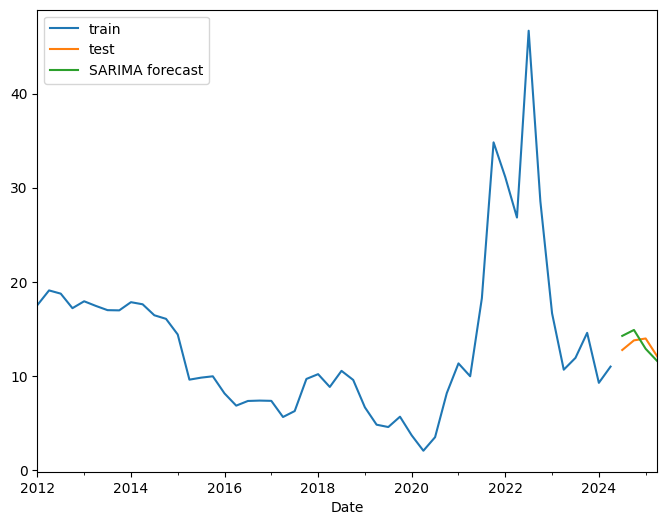

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

lng_train.plot(label="train")
lng_test.plot(label="test")
y_pred_seasonal.plot( label="SARIMA forecast")
plt.legend()

plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(lng_test, y_pred_seasonal))
print(f'RMSE: {rmse}')
print(f'AIC: {seasonal_model.aic}')

RMSE: 1.10814761539299
AIC: 309.71371147632533


In [ ]:
#best aic

seasonal_model = SARIMAX(lng_train,
                         order=(2, 2, 2),
                         seasonal_order=(1, 1, 1, 4),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

y_pred_seasonal = seasonal_model.predict(start="2024-07-01", end="2025-04-01")

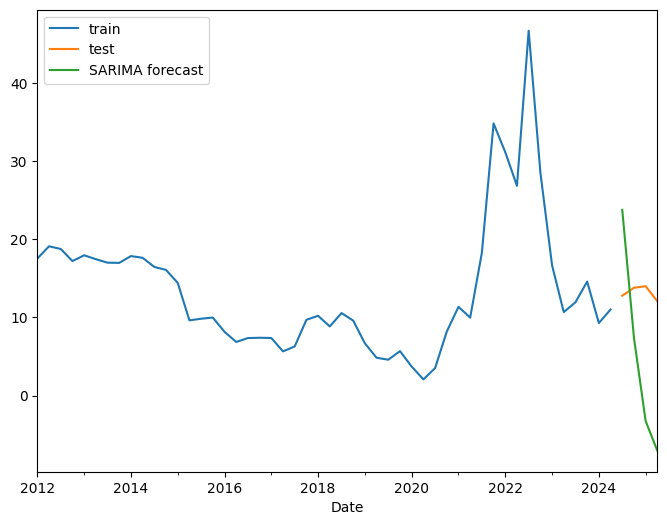

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

lng_train.plot(label="train")
lng_test.plot(label="test")
y_pred_seasonal.plot( label="SARIMA forecast")
plt.legend()

plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(lng_test, y_pred_seasonal))
print(f'RMSE: {rmse}')
print(f'AIC: {seasonal_model.aic}')

RMSE: 14.361612093702119
AIC: 247.12671051311284


In [ ]:
#experimenting more

seasonal_model = SARIMAX(lng_train,
                         order=(2, 2, 2),
                         seasonal_order=(0, 1, 1, 4),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

y_pred_seasonal = seasonal_model.predict(start="2024-07-01", end="2025-04-01")

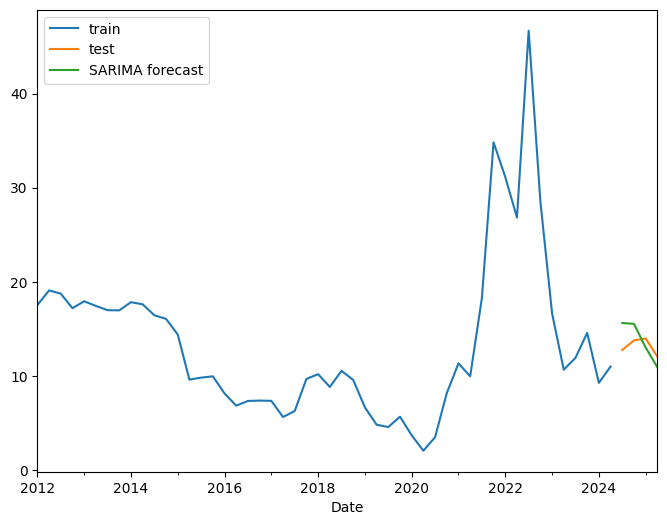

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

lng_train.plot(label="train")
lng_test.plot(label="test")
y_pred_seasonal.plot( label="SARIMA forecast")
plt.legend()

plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(lng_test, y_pred_seasonal))
print(f'RMSE: {rmse}')
print(f'AIC: {seasonal_model.aic}')

RMSE: 1.8339093782717846
AIC: 254.11931383391394


In [ ]:
#experimenting more

seasonal_model = SARIMAX(lng_train,
                         order=(0, 1, 2),
                         seasonal_order=(0, 1, 1, 4),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

y_pred_seasonal = seasonal_model.predict(start="2024-07-01", end="2025-04-01")

In [ ]:
rmse = np.sqrt(mean_squared_error(lng_test, y_pred_seasonal))
print(f'RMSE: {rmse}')
print(f'AIC: {seasonal_model.aic}')

RMSE: 1.438850121152097
AIC: 254.24429932431394


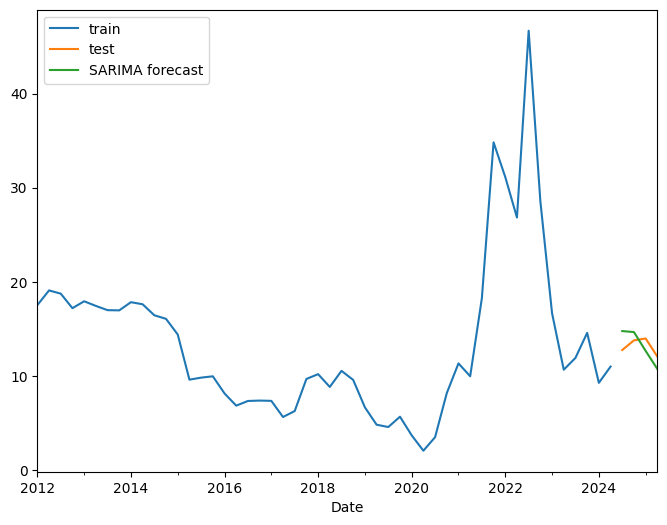

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

lng_train.plot(label="train")
lng_test.plot(label="test")
y_pred_seasonal.plot( label="SARIMA forecast")
plt.legend()

plt.show()

#### 1st and last model seems to work best. to compare against full data and pick the hyperparameters resulting in lowest AIC

In [ ]:
lng_train = tariff['lng_price_sgd_MMBtu']

In [ ]:
seasonal_model = SARIMAX(lng_train,
                         order=(0, 1, 2),
                         seasonal_order=(0, 1, 1, 4),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

y_pred_seasonal = seasonal_model.predict(start="2025-07-01", end="2026-10-01")

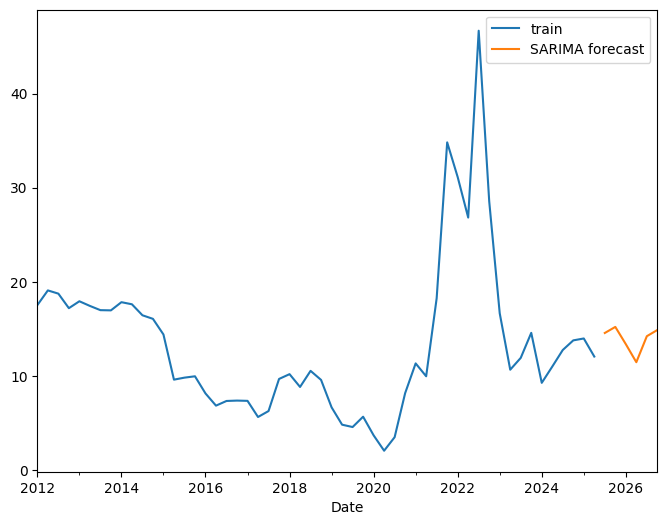

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

lng_train.plot(label="train")
y_pred_seasonal.plot( label="SARIMA forecast")
plt.legend()

plt.show()

In [ ]:
print(f'AIC: {seasonal_model.aic}')

AIC: 275.85007939993113


In [ ]:
seasonal_model = SARIMAX(lng_train,
                         order=(0, 0, 0),
                         seasonal_order=(0, 1, 1, 4),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

y_pred_seasonal = seasonal_model.predict(start="2025-07-01", end="2026-10-01")

In [ ]:
print(f'AIC: {seasonal_model.aic}')

AIC: 335.01618200896894


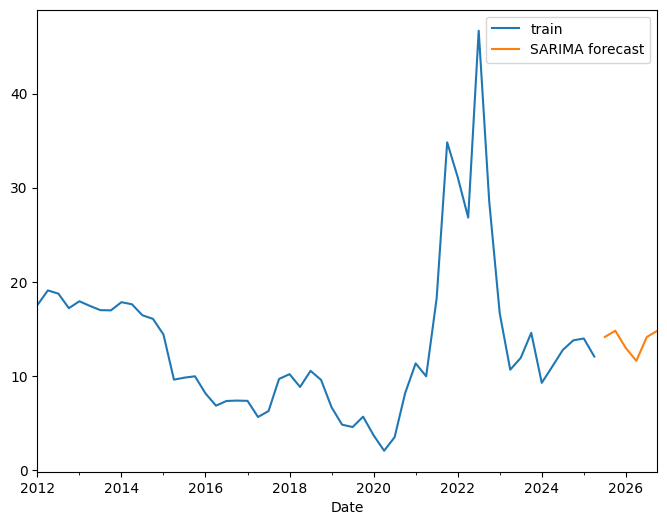

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

lng_train.plot(label="train")
y_pred_seasonal.plot( label="SARIMA forecast")
plt.legend()

plt.show()

### d = 1 and q = 2 seems to work better with full data

In [ ]:
seasonal_model = SARIMAX(lng_train,
                         order=(0, 1, 2),
                         seasonal_order=(0, 1, 1, 4),
                         enforce_stationarity=False,
                         enforce_invertibility=False).fit()

y_pred_seasonal = seasonal_model.predict(start="2025-07-01", end="2026-10-01")

In [ ]:
lng_pred = y_pred_seasonal

### Now to put it altogether for the tariff SARIMAX

In [ ]:
model = SARIMAX(tariff['low_tension_domestic'],
                exog=tariff[["oil_price_sgd_barrel", "lng_price_sgd_MMBtu"]],
                order=(1,1,2),               # p,d,q
                seasonal_order=(1,0,1,4),   # P,D,Q,s
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                low_tension_domestic   No. Observations:                   54
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 4)   Log Likelihood                 -72.987
Date:                             Thu, 24 Jul 2025   AIC                            161.975
Time:                                     16:14:52   BIC                            176.604
Sample:                                 01-01-2012   HQIC                           167.455
                                      - 04-01-2025                                         
Covariance Type:                               opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
oil_price_usd_barrel    -0.0085      0.018     -0.476      0.634      -0.044       0.0

In [ ]:
exog_forecast = pd.concat([oil_pred, lng_pred], axis=1)
exog_forecast.columns = ['oil_price_sgd_barrel', 'lng_price_sgd_MMBtu']

forecast = results.predict(start='2025-07-01',
                           end='2026-10-01',
                           exog = exog_forecast)

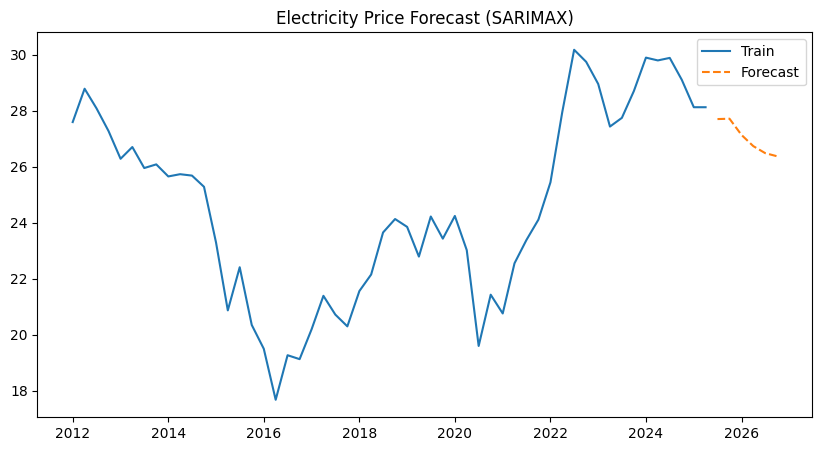

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(tariff['low_tension_domestic'].index, tariff['low_tension_domestic'], label="Train")
plt.plot(forecast.index, forecast, label="Forecast", linestyle="--")
plt.legend()
plt.title("Electricity Price Forecast (SARIMAX)")
plt.show()

### Forecasted tariffs

In [ ]:
forecast

2025-07-01    27.697425
2025-10-01    27.709799
2026-01-01    27.129634
2026-04-01    26.730980
2026-07-01    26.481339
2026-10-01    26.368624
Freq: QS-JAN, Name: predicted_mean, dtype: float64

In [ ]:
#aic of final model
results.aic

np.float64(161.97493575948235)

### Now let's try some regression models

In [ ]:
train = tariff.iloc[:-4]
test = tariff.iloc[-4:]

y_train = train["low_tension_domestic"]
y_test = test["low_tension_domestic"]
X_train = train[["oil_price_sgd_barrel", "lng_price_sgd_MMBtu"]]
X_test = test[["oil_price_sgd_barrel", "lng_price_sgd_MMBtu"]]

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
lr = LinearRegression()

In [ ]:
lr.fit(X_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
y_null = np.zeros_like(y_test, dtype=float)
y_null.fill(y_train.mean())
null_rmse = metrics.root_mean_squared_error(y_test, y_null)
null_rmse

4.568275630913708

In [ ]:
y_pred = lr.predict(X_test)
model_rmse = metrics.root_mean_squared_error(y_test, y_pred)
model_rmse

4.408572356624379

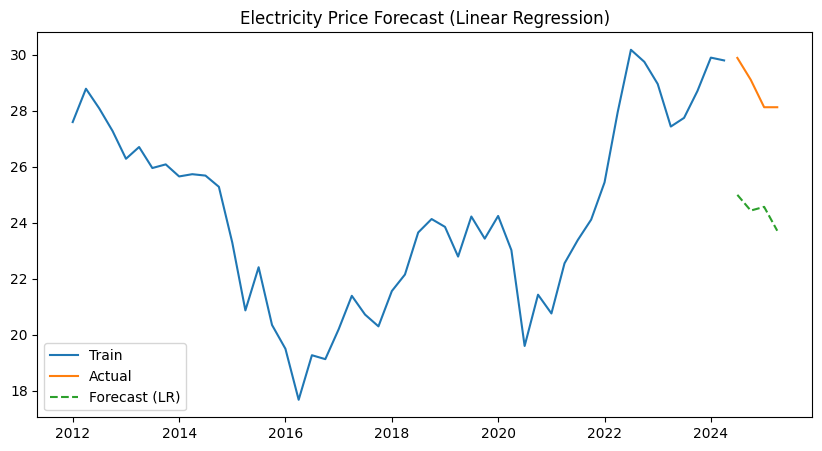

In [ ]:
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Plot
plt.figure(figsize=(10,5))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_pred_series.index, y_pred_series, label="Forecast (LR)", linestyle="--")
plt.legend()
plt.title("Electricity Price Forecast (Linear Regression)")
plt.show()

In [ ]:
r2 = r2_score(y_test, y_pred_series)
r2

-34.64350139579597

In [ ]:
#randomforest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, random_state = 100)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rmse =metrics.root_mean_squared_error(y_test, y_pred)
print("RMSE:", rmse)

RMSE: 4.514055322822256


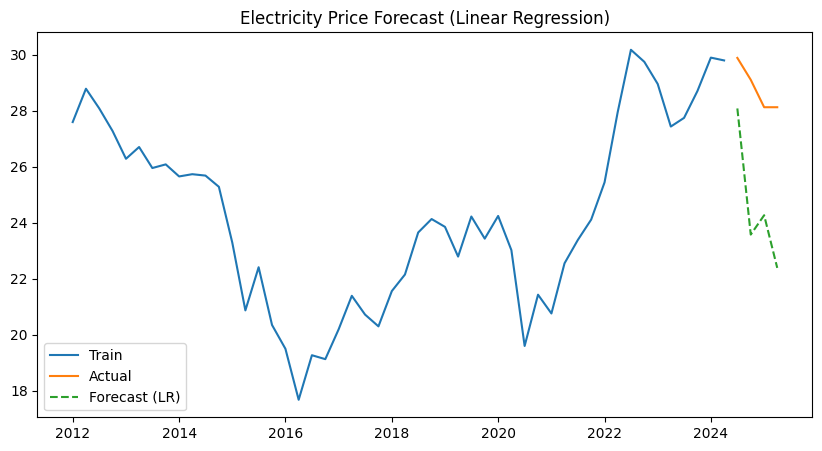

In [ ]:
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Plot
plt.figure(figsize=(10,5))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_pred_series.index, y_pred_series, label="Forecast (LR)", linestyle="--")
plt.legend()
plt.title("Electricity Price Forecast (Linear Regression)")
plt.show()

In [ ]:
r2 = r2_score(y_test, y_pred)
r2

-36.36957582412537

### Did not work well, as expected. now to combine the predictitions from the SARIMA & SARIMAX models with the original data

In [ ]:
forecast

2025-07-01    27.697425
2025-10-01    27.709799
2026-01-01    27.129634
2026-04-01    26.730980
2026-07-01    26.481339
2026-10-01    26.368624
Freq: QS-JAN, Name: predicted_mean, dtype: float64

In [ ]:
lng_pred

2025-07-01    14.572443
2025-10-01    15.216865
2026-01-01    13.385043
2026-04-01    11.469224
2026-07-01    14.230646
2026-10-01    14.889109
Freq: QS-JAN, Name: predicted_mean, dtype: float64

In [ ]:
oil_pred

2025-07-01    61.749013
2025-10-01    55.971976
2026-01-01    54.821297
2026-04-01    57.485486
2026-07-01    58.140885
2026-10-01    55.288971
Freq: QS-JAN, Name: predicted_mean, dtype: float64

In [ ]:
merged = pd.concat([forecast,oil_pred,lng_pred],axis=1)

In [ ]:
merged.columns = ['low_tension_domestic','oil_price_sgd_barrel','lng_price_sgd_MMBtu']

In [ ]:
merged

,low_tension_domestic,oil_price_usd_barrel,lng_price_usd_MMBtu
2025-07-01,27.697425,61.749013,14.572443
2025-10-01,27.709799,55.971976,15.216865
2026-01-01,27.129634,54.821297,13.385043
2026-04-01,26.730980,57.485486,11.469224
2026-07-01,26.481339,58.140885,14.230646
2026-10-01,26.368624,55.288971,14.889109


In [ ]:
merged.to_csv('predicted.csv')

In [ ]:
tariff.to_csv('tariff_oilgas_quarterly.csv')